In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import pandas as pd
# make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

In [2]:
# https://archive.ics.uci.edu/ml/datasets/Auto+MPG
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

In [3]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
# clean data
dataset = dataset.dropna()
#covert categorical 'Origin' data into one-hot encoded data
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1
dataset['Europe'] = (origin == 2)*1
dataset['Japan'] = (origin == 3)*1

In [5]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,0,0


In [6]:
# Split data into train and test dataset
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

print(dataset.shape, train_dataset.shape, test_dataset.shape)
train_dataset.describe().transpose()

(392, 10) (314, 10) (78, 10)


,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [7]:
# Split features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [8]:
def plot(feature, x=None, y=None):
  plt.figure(figsize=(10,8))
  plt.scatter(train_features[feature], train_labels, label='Data')
  if x is not None and y is not None:
    plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel(feature)
  plt.ylabel('MPG')
  plt.legend()

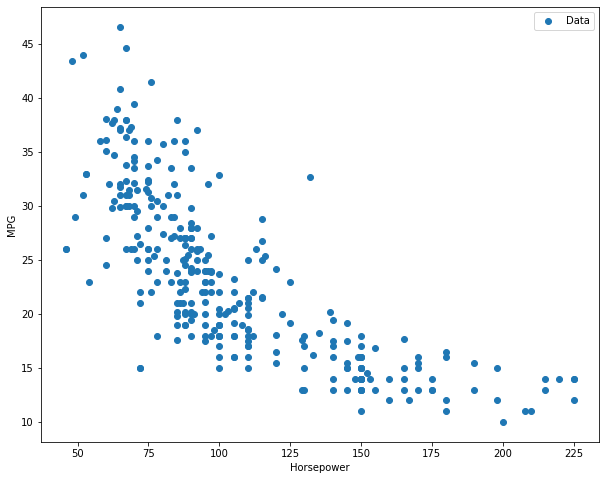

In [9]:
plot('Horsepower')

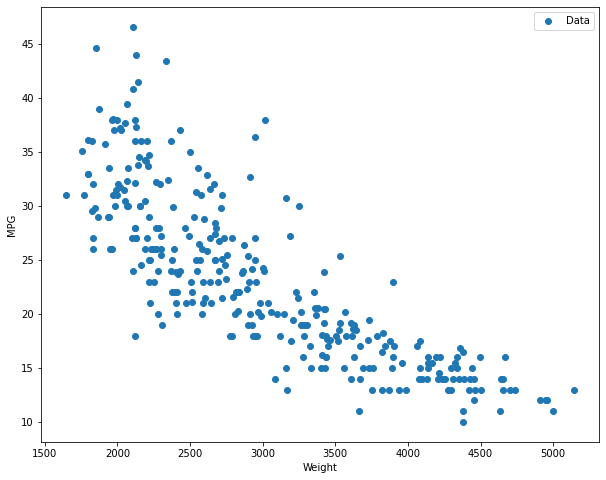

In [10]:
plot('Weight')

In [11]:
# Normalize
print(train_dataset.describe().transpose()[['mean', 'std']])

# Normalization layer
normalizer = preprocessing.Normalization()

# adapt to the data
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

                     mean         std
MPG             23.310510    7.728652
Cylinders        5.477707    1.699788
Displacement   195.318471  104.331589
Horsepower     104.869427   38.096214
Weight        2990.251592  843.898596
Acceleration    15.559236    2.789230
Model Year      75.898089    3.675642
USA              0.624204    0.485101
Europe           0.178344    0.383413
Japan            0.197452    0.398712
[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.624    0.178
     0.197]]


In [12]:
# When the layer is called it returns the input data, with each feature independently normalized:
# (input-mean)/stddev
first = np.array(train_features[:1])
print('First Example:', first)
print('Normalized:', normalizer(first).numpy()) # each value within a distribution with mean 0 and std 1

First Example: [[   4.    90.    75.  2125.    14.5   74.     1.     0.     0. ]]
Normalized: [[-0.871 -1.011 -0.785 -1.027 -0.38  -0.517  0.776 -0.466 -0.496]]


In [47]:
# Regression
# 1. Normalize the input horsepower
# 2. Apply a linear transformation (y = m*x + b) to produce 1 output using layers.Dense

feature = 'Horsepower'
single_feature = np.array(train_features[feature])
print(single_feature.shape, train_features.shape)

# Normalization layer
single_feature_normalizer = layers.Normalization(axis=None)

# adapt to the feature
single_feature_normalizer.adapt(single_feature)

(314,) (314, 9)


In [48]:
# Sequential model 
single_feature_model = keras.models.Sequential([
    layers.Input(shape=(1,)),
    single_feature_normalizer,
    layers.Dense(units=1) # linear model (point 2 , above kernel)
])

In [49]:
single_feature_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_16 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_14 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [51]:
# loss and optimizer
loss = keras.losses.MeanAbsoluteError() # this is one possiblity, other being "MeanSquaredError" ie (y_p - y)**2
optim = keras.optimizers.Adam(learning_rate=0.1)
# compile
single_feature_model.compile(optimizer=optim, loss=loss)

In [52]:
history = single_feature_model.fit(
    train_features[feature], train_labels, 
    epochs=100, 
    verbose=1,
    # calculate validation results on 20% of the training data
    validation_split = 0.2
) 

Epoch 1/100
8/8 [==============================] - 1s 23ms/step - loss: 22.8632 - val_loss: 22.9368
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 22.0649 - val_loss: 22.1372
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 21.2630 - val_loss: 21.3371
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 20.4630 - val_loss: 20.5370
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 19.6618 - val_loss: 19.7372
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 18.8616 - val_loss: 18.9372
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 18.0607 - val_loss: 18.1372
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 17.2607 - val_loss: 17.3372
Epoch 9/100
8/8 [==============================] - 0s 5ms/step - loss: 16.4636 - val_loss: 16.5373
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 15.6624 - val_loss: 15.7371
Epoch 11

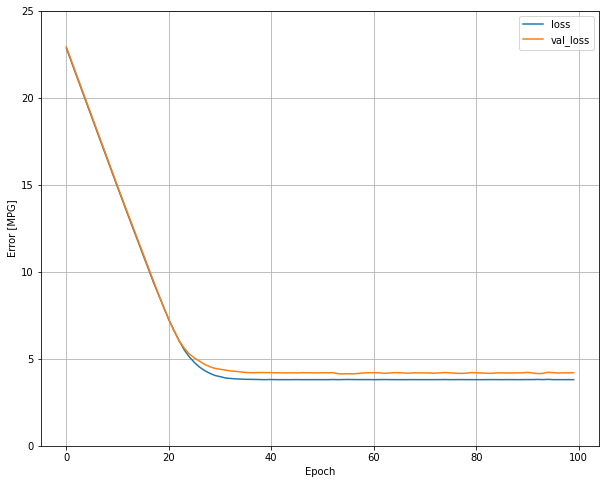

In [54]:
def plot_loss(history):
  plt.figure(figsize=(10,8))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0,25])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [56]:
single_feature_model.evaluate(
    test_features[feature],
    test_labels, verbose=1)

3/3 [==============================] - 0s 6ms/step - loss: 3.6484


3.6484313011169434

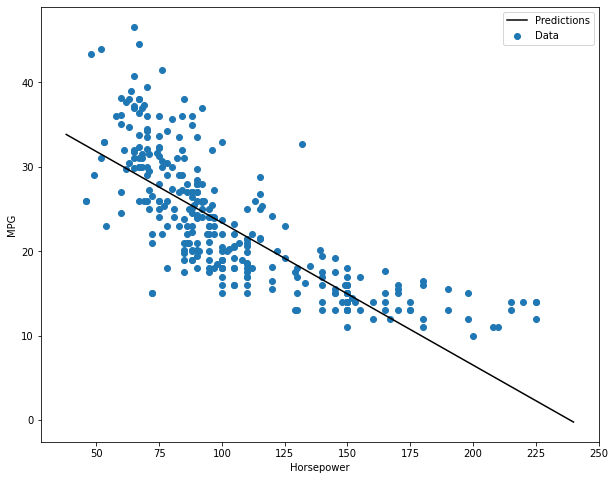

In [58]:
# predict and plot 
range_min = np.min(test_features[feature]) - 10
range_max = np.max(test_features[feature]) + 10
x = tf.linspace(range_min, range_max, 200)
y = single_feature_model.predict(x)
plot(feature, x, y)

In [62]:
# Extending the result to a Deep Neural Network (DNN)
dnn_model = keras.Sequential([
    layers.Input(shape=(1,)),
    single_feature_normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [63]:
dnn_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(0.001))
dnn_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_16 (Normaliza  multiple                 3         
 tion)                                                           
                                                                 
 dense_20 (Dense)            (None, 64)                128       
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [68]:
# fitting the dnn model
dnn_model.fit(
    train_features[feature], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100
)

In [69]:
# dnn model evaluation
dnn_model.evaluate(test_features[feature], test_labels, verbose=1)

3/3 [==============================] - 0s 4ms/step - loss: 2.7810


2.7809553146362305

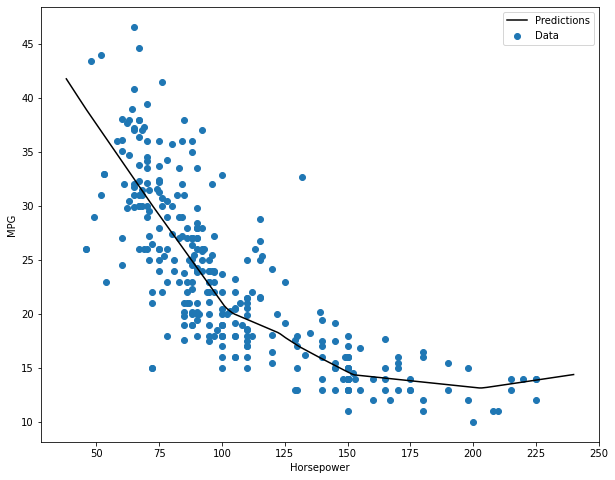

In [70]:
# predict and plot
x = tf.linspace(range_min, range_max, 200)
y = dnn_model.predict(x)
plot(feature, x, y)

In [71]:
# The above two models (linear regressions and deep neural networks) used only one feature, now we are going to use all features 
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss=loss
)

In [72]:
linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    verbose=0,
    # Calculation of validation results on 20% of the training data
    validation_split=0.2
)

In [73]:
linear_model.evaluate(
    test_features,
    test_labels, 
    verbose=1
)

3/3 [==============================] - 0s 5ms/step - loss: 2.4710


2.470980167388916